In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *
import email
from nltk.tokenize.regexp import RegexpTokenizer
import itertools
import re
from nltk.corpus import stopwords
import string
import nltk
from sklearn.metrics.pairwise import linear_kernel

## Load the Enron dataset

In [2]:
emails_df = pd.read_csv('../../Data/enron_emails.csv')

In [3]:
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
print('number of documents in the Enron dataset are:', len(emails_df), 'we will take a subset of this.')

('number of documents in the Enron dataset are:', 517401, 'we will take a subset of this.')


## Take a subset of the dataset for exploration

In [3]:
emails_df_sub = emails_df.sample(5000, random_state=1).reset_index(drop=True)

In [6]:
emails_df_sub['message'][1]

'Message-ID: <29110382.1075845717882.JavaMail.evans@thyme>\nDate: Tue, 15 May 2001 11:03:00 -0700 (PDT)\nFrom: kay.mann@enron.com\nTo: sheila.tweed@enron.com\nSubject: Re: Override letter\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Kay Mann\nX-To: Sheila Tweed\nX-cc: \nX-bcc: \nX-Folder: \\Kay_Mann_June2001_1\\Notes Folders\\All documents\nX-Origin: MANN-K\nX-FileName: kmann.nsf\n\nAbsolutely.  \n\n\nFrom: Sheila Tweed@ECT on 05/15/2001 06:02 PM\nTo: Kay Mann/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: Override letter  \n\nGood point!  Can Peter start to draft an override letter?\n\n\n\n\tKay Mann@ENRON\n\t05/15/2001 05:55 PM\n\t\t \n\t\t To: pthompson@akllp.com\n\t\t cc: Sheila Tweed/HOU/ECT@ECT, Roseann Engeldorf/Enron@EnronXGate, Scott \nDieball/ENRON_DEVELOPMENT@ENRON_DEVELOPMENt, John G \nRigby/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT\n\t\t Subject: Override letter\n\nAs a reminder to all of us, we will need a form override lette

## Pre-processing the data

We would like to parse the message column into the respective columns within it. 
1. Make a new column for each key in the message column
2. Split the email addresses 
3. Extract user name from file name

In [4]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df_sub['message']))
emails_df_sub.drop('message', axis=1, inplace=True)

In [8]:
messages[0].items()

[('Message-ID', '<17820178.1075846925335.JavaMail.evans@thyme>'),
 ('Date', 'Tue, 4 Jan 2000 08:20:00 -0800 (PST)'),
 ('From', 'tana.jones@enron.com'),
 ('To', 'alicia.goodrow@enron.com'),
 ('Subject', 'Re: Dinner'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Tana Jones'),
 ('X-To', 'Alicia Goodrow'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', '\\Tanya_Jones_Dec2000\\Notes Folders\\All documents'),
 ('X-Origin', 'JONES-T'),
 ('X-FileName', 'tjones.nsf')]

In [5]:
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df_sub[key] = [doc[key] for doc in messages]

In [6]:
# Parse content from emails
emails_df_sub['content'] = list(map(get_text_from_email, messages))

In [7]:
# Split multiple email addresses
emails_df_sub['From'] = emails_df_sub['From'].map(split_email_addresses)
emails_df_sub['To'] = emails_df_sub['To'].map(split_email_addresses)

In [8]:
# Extract the root of 'file' as 'user'
emails_df_sub['user'] = emails_df_sub['file'].map(lambda x:x.split('/')[0])
del messages

In [13]:
emails_df_sub.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,jones-t/all_documents/634.,<17820178.1075846925335.JavaMail.evans@thyme>,"Tue, 4 Jan 2000 08:20:00 -0800 (PST)",(tana.jones@enron.com),(alicia.goodrow@enron.com),Re: Dinner,1.0,text/plain; charset=us-ascii,7bit,Tana Jones,Alicia Goodrow,,,\Tanya_Jones_Dec2000\Notes Folders\All documents,JONES-T,tjones.nsf,"It would be nice if you could be at my dinner,...",jones-t
1,mann-k/all_documents/5690.,<29110382.1075845717882.JavaMail.evans@thyme>,"Tue, 15 May 2001 11:03:00 -0700 (PDT)",(kay.mann@enron.com),(sheila.tweed@enron.com),Re: Override letter,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,Sheila Tweed,,,\Kay_Mann_June2001_1\Notes Folders\All documents,MANN-K,kmann.nsf,Absolutely. \n\n\nFrom: Sheila Tweed@ECT on 0...,mann-k
2,dasovich-j/sent/423.,<6812040.1075843194135.JavaMail.evans@thyme>,"Thu, 28 Sep 2000 08:59:00 -0700 (PDT)",(jeff.dasovich@enron.com),(christine.piesco@oracle.com),Teams,1.0,text/plain; charset=us-ascii,7bit,Jeff Dasovich,Christine.Piesco@oracle.com,,,\Jeff_Dasovich_Dec2000\Notes Folders\Sent,DASOVICH-J,jdasovic.nsf,Christine:\n\nMy apologies. My schedule melte...,dasovich-j
3,kaminski-v/var/63.,<21547648.1075856642126.JavaMail.evans@thyme>,"Mon, 9 Oct 2000 01:23:00 -0700 (PDT)",(tanya.tamarchenko@enron.com),(vince.kaminski@enron.com),Re: FYI: UK Var issues,1.0,text/plain; charset=us-ascii,7bit,Tanya Tamarchenko,Vince J Kaminski,,,\Vincent_Kaminski_Jun2001_5\Notes Folders\Var,Kaminski-V,vkamins.nsf,"Vince, \nUK VAR breached the limit last week.\...",kaminski-v
4,mann-k/_sent_mail/3208.,<12684200.1075846107179.JavaMail.evans@thyme>,"Fri, 13 Oct 2000 01:50:00 -0700 (PDT)",(kay.mann@enron.com),"(ben.jacoby@enron.com, lisa.bills@enron.com)",Change Order #5--Pleasanton Transformer,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,"Lisa Bills, Ben Jacoby",,,\Kay_Mann_June2001_4\Notes Folders\'sent mail,MANN-K,kmann.nsf,Any problems/comments?\n----------------------...,mann-k


In [14]:
print('shape of the dataframe:', emails_df_sub.shape)
# Find number of unique values in each columns
for col in emails_df_sub.columns:
    print(col, emails_df_sub[col].nunique())

('shape of the dataframe:', (5000, 18))
('file', 5000)
('Message-ID', 5000)
('Date', 4891)
('From', 1666)
('To', 2864)
('Subject', 4465)
('Mime-Version', 1)
('Content-Type', 2)
('Content-Transfer-Encoding', 2)
('X-From', 1929)
('X-To', 3312)
('X-cc', 1035)
('X-bcc', 4)
('X-Folder', 1378)
('X-Origin', 243)
('X-FileName', 376)
('content', 4924)
('user', 149)


## Group the emails by the user 

In [9]:
emails_df_sub_grouped = emails_df_sub.groupby('user')['content'].apply(lambda x: x.sum()).reset_index().groupby('user')['content'].apply(lambda x: x.sum()).reset_index()

In [10]:
from_df = emails_df_sub.groupby('X-From')['content'].apply(lambda x: x.sum()).reset_index().groupby('X-From')['content'].apply(lambda x: x.sum()).reset_index()

## More pre-processing

Now, we can pre-process the emails by doing the following:
1. removing website urls
2. standardizing words
3. removing puncuation
4. remove all numbers
5. removing stop words
6. removing chat words

In [17]:
stop = stopwords.words('english')
exclude = set(string.punctuation)
exclude.update({'\n', '\t', '75pt', 'font size','padding', '0pt', 'td', 'font'})
chat_words_lower = sorted(set(w.lower() for w in nltk.corpus.nps_chat.words()))

In [18]:
print exclude

set(['\t', '\n', 'font size', 'font', '!', '#', '"', '%', '$', "'", '&', ')', '(', '+', '*', '-', ',', '/', '.', ';', ':', '=', '<', '?', '>', '@', 'padding', 'td', '0pt', '[', ']', '\\', '_', '^', '`', '75pt', '{', '}', '|', '~'])


In [19]:
def clean(doc):
    try:
        doc['content'] = ''.join(''.join(s)[:2] for _, s in itertools.groupby(doc['content']))
        doc['content'] = re.sub(r'http\S+', '', doc['content'])
        doc['content'] = ''.join([i for i in doc['content'] if not i.isdigit()])
        doc['content'] = ' '.join([i for i in doc['content'].lower().split(' ') if i not in stop])
        doc['content'] = ' '.join([i for i in doc['content'].lower().split(' ') if i not in chat_words_lower])
        doc['content'] = ''.join(ch for ch in doc['content'] if ch not in exclude)
    except:
        doc['content'] = ''
    return doc['content']

In [20]:
emails_df_sub_grouped['content'] = emails_df_sub_grouped.apply(clean, axis=1)

In [21]:
from_df['content']=from_df.apply(clean, axis=1)
from_df.head()

,X-From,content
0,""" EquityAlert.com Special Offer "" <support@equ...",imageimageimageimageimageimageimageimageimagei...
1,"""1-800-FLOWERS.COM"" <1800flowers@1800flowers.f...",connection flowerscom students survival stud...
2,"""Aaron Roffwarg"" <aroffwarg@bracepatt.com>",attached review documents amendment securities...
3,"""Adib, Parviz"" <Parviz.Adib@puc.state.tx.us>",attached puc staff regardingthe ercot protocol...
4,"""Al Arfsten"" <arfsten@bflassociates.com>@ENRON",vince returned breakfast earliest convenience ...


In [25]:
from textblob import TextBlob
from_df['sentiment'] = (TextBlob(str(from_df['content']))).sentiment.polarity

In [26]:
from_df.head()

,X-From,content,sentiment
0,""" EquityAlert.com Special Offer "" <support@equ...",imageimageimageimageimageimageimageimageimagei...,0.024275
1,"""1-800-FLOWERS.COM"" <1800flowers@1800flowers.f...",connection flowerscom students survival stud...,0.024275
2,"""Aaron Roffwarg"" <aroffwarg@bracepatt.com>",attached review documents amendment securities...,0.024275
3,"""Adib, Parviz"" <Parviz.Adib@puc.state.tx.us>",attached puc staff regardingthe ercot protocol...,0.024275
4,"""Al Arfsten"" <arfsten@bflassociates.com>@ENRON",vince returned breakfast earliest convenience ...,0.024275


In [22]:
emails_df_sub_grouped.head()

,user,content
0,allen-p,unsubscribe click here if received error reply...
1,arnold-j,themerrol mclaughlinenron amto arnoldhouectect...
2,arora-h,request pending approval days click review upo...
3,badeer-r,thursday attached presentation ferc staff the ...
4,bailey-s,edwardi noticed senior designation strange yes...


<h2>WordCloud!</h2>

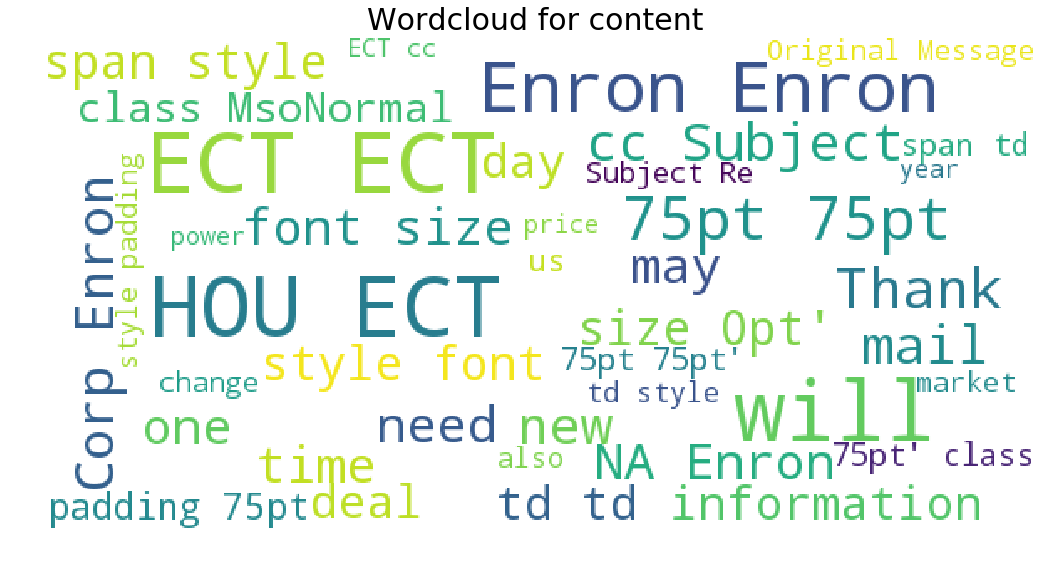

In [20]:
from wordcloud import WordCloud



plt.figure(figsize=(18,12))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(' '.join(test['content']))
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for content", fontsize=30)
plt.axis("off")
plt.show()

In [ ]:
training = emails_df_sub_grouped.sample(frac=0.7, random_state=0).reset_index(drop=True)
testing = emails_df_sub_grouped.loc[~emails_df_sub_grouped.index.isin(training.index)].reset_index(drop=True)

In [ ]:
testing

In [ ]:
training_corpus = training.values.tolist()
testing_corpus = testing.values.tolist()

## Applying CountVectorizer

In [ ]:
# import
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# instantiate
vect = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.5, max_df=0.95, stop_words = 'english')

In [ ]:
# fit & transform
tf_matrix = vect.fit_transform([content for file, content in training_corpus])

print('Number of documents:', tf_matrix.shape[0], ', number of features:', tf_matrix.shape[1])

In [ ]:
vect.get_feature_names()

In [ ]:
# convert sparse matrix to a dense matrix
tf_matrix.toarray()

In [ ]:
# examine the vocabulary and document-term matrix together
feature_matrix = pd.DataFrame(tf_matrix.toarray(), columns=vect.get_feature_names())
feature_matrix

## Applying TF_IDF

The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.
    
 The formula that is used to compute the tf-idf of term t is
    tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as
    idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
    where n is the total number of documents and df(d, t) is the
    document frequency; the document frequency is the number of documents d
    that contain term t. The effect of adding "1" to the idf in the equation
    above is that terms with zero idf, i.e., terms  that occur in all documents
    in a training set, will not be entirely ignored.
    (Note that the idf formula above differs from the standard
    textbook notation that defines the idf as
    idf(d, t) = log [ n / (df(d, t) + 1) ]).

In [ ]:
# import
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# instantiate
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.5, max_df=0.95, stop_words = 'english', norm='l2')

In [ ]:
# fit & transform
tfidf_matrix = tf.fit_transform([content for file, content in training_corpus])

print('Number of documents:', tfidf_matrix.shape[0], ', number of features:', tfidf_matrix.shape[1])

In [ ]:
tf.get_feature_names()

In [ ]:
# convert sparse matrix to a dense matrix
tfidf_matrix.toarray()

In [ ]:
# examine the vocabulary and document-term matrix together
feature_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
feature_matrix

## Testing Similarity using Cosine

For this part, we are taking an observation outside of the training set (i.e. in the testing set) and t

In [ ]:
testing_corpus[13]

In [ ]:
new_email = [testing_corpus[13]]

In [ ]:
new = tf.transform([content for file, content in new_email])

In [ ]:
def find_similar(tfidf_matrix, new_movie, top_n = 1000):
    cosine_similarities = linear_kernel(new_movie, tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1]]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [ ]:
similarity = pd.DataFrame()
for index, score in find_similar(tfidf_matrix, new):
    similarity = similarity.append(pd.DataFrame({'similarity_score':score, 'person':training_corpus[index][0]}, index=[0]), ignore_index=True)
similarity.head()

http://www.foxnews.com/story/2004/07/08/fast-facts-key-enron-players.html